In [ ]:
"""Import required libraries"""
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [3]:
"""Load data and make it easier to work with """
san_diego = pd.read_csv("../Data/SANDIEGO.csv")
san_diego.rename(columns={"SAND706URN": "rate"}, inplace=True)
san_diego.rename(columns={"observation_date": "date"}, inplace=True)
san_diego.set_index("date", inplace=True)
san_diego.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424 entries, 1990-01-01 to 2025-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rate    424 non-null    float64
dtypes: float64(1)
memory usage: 6.6+ KB


In [4]:
"""Calculate rolling change from month to month, drop first entry for lack of prior knowledge"""
san_diego["change"] = san_diego["rate"].diff()
san_diego.dropna(inplace=True)
san_diego.head()

,rate,change
date,,
1990-02-01,3.8,-0.2
1990-03-01,3.7,-0.1
1990-04-01,3.9,0.2
1990-05-01,4.1,0.2
1990-06-01,4.5,0.4


In [18]:
"""Divide the data between training and testing data - All but most recent year as training, most recent year as test"""
san_diego_train = san_diego[san_diego.index < "2024-05-01"]
san_diego_test = san_diego[san_diego.index >= "2024-05-01"]

assert len(san_diego_train) + len(san_diego_test) == len(san_diego)
san_diego_train.tail()

# Dived traing/test data into features and targets
train_features = san_diego_train["rate"].values.reshape(-1, 1)
train_labels = san_diego_train["change"].values.reshape(-1, 1)
test_features = san_diego_test["rate"].values.reshape(-1, 1)
test_labels = san_diego_test["change"].values.reshape(-1, 1)


In [19]:
"""Define tensorflow sequential model, train and predict using train and test data"""
model = Sequential()
model.add(LSTM(50, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

# Train the model
model.fit(train_features, train_labels, epochs=100, validation_data=(test_features, test_labels), callbacks=[EarlyStopping(monitor="val_loss", patience=5)])

# Make predictions on the test data
predictions = model.predict(test_features)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.1194 - val_loss: 0.1156
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4142 - val_loss: 0.1151
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6524 - val_loss: 0.1149
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5479 - val_loss: 0.1152
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3848 - val_loss: 0.1147
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4120 - val_loss: 0.1147
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3345 - val_loss: 0.1145
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6319 - val_loss: 0.1138
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4609 - val_loss: 0.1164
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7427 - val_loss: 0.1164
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1928 - val_loss: 0.1163
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

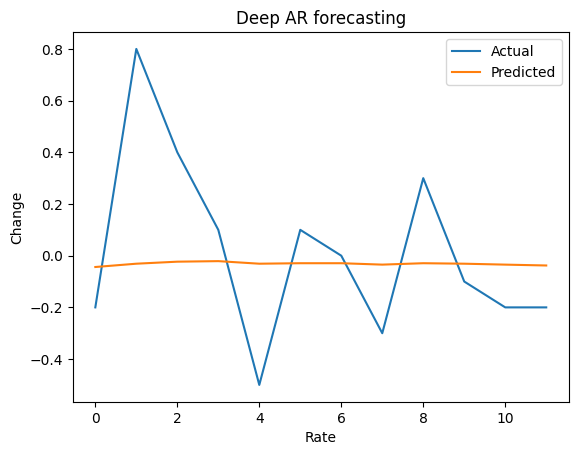

In [20]:
"""Plot actual data and predicted values"""
plt.title("Deep AR forecasting")
plt.ylabel("Change")
plt.xlabel("Rate")
plt.plot(test_labels, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.show()